In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

Stationarity/Non-Stationarity:

A commonly untested assumption in time series analysis is the stationarity of the data. Data are stationary when the parameters of the data generating process do not change over time. As an example, let's consider two series, A and B. Series A is generated from a stationary process with fixed parameters, series B is generated with parameters that change over time.

In [3]:
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

Series A

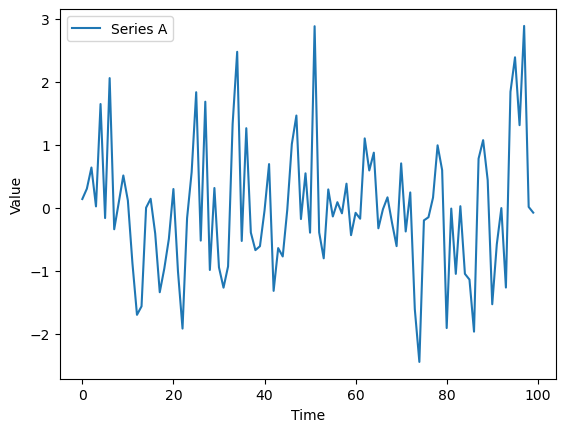

In [4]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T), dtype='float64')
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)

plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A']);

Series B


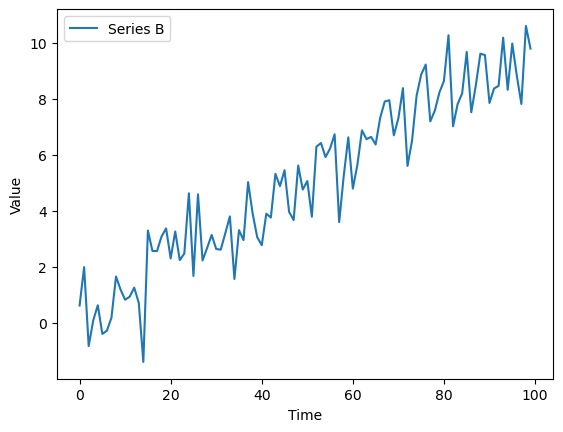

In [5]:
# Set the number of datapoints
T = 100

B = pd.Series(index=range(T), dtype="float64")
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_datapoint(params)

plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B']);

Why Non-Stationarity is Dangerous:

Many statistical tests, deep down in the fine print of their assumptions, require that the data being tested are stationary. Also, if you naively use certain statistics on a non-stationary data set, you will get garbage results. As an example, let's take an average through our non-stationary B.

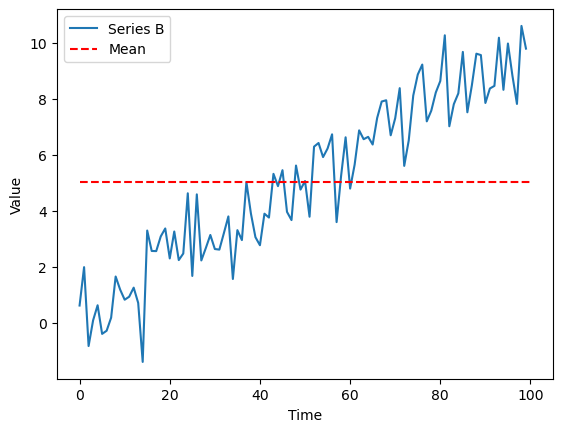

In [6]:
m = np.mean(B)

plt.plot(B)
plt.hlines(m, 0, len(B), linestyles='dashed', colors='r')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B', 'Mean']);

Testing for Stationarity:

Now we want to check for stationarity using a statistical test.

In [7]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False

In [8]:
check_for_stationarity(A);
check_for_stationarity(B);

p-value = 1.5262484274608627e-12 The series A is likely stationary.
p-value = 0.7113103205059966 The series B is likely non-stationary.


Sure enough, the changing mean of the series makes it non-stationary. Let's try an example that might be a little more subtle.

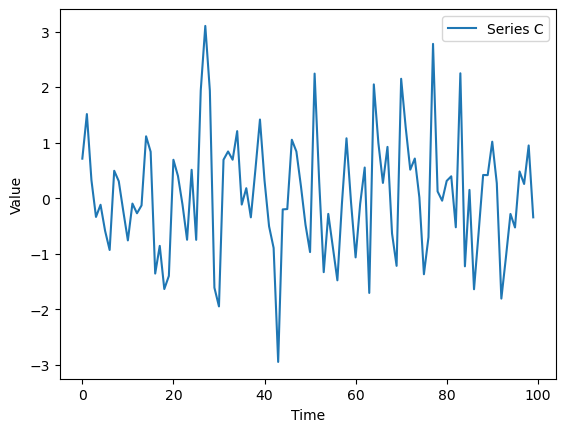

In [9]:
# Set the number of datapoints
T = 100

C = pd.Series(index=range(T), dtype="float64")
C.name = 'C'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (np.sin(t), 1)
    C[t] = generate_datapoint(params)

plt.plot(C)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series C']);


A cyclic movement of the mean will be very difficult to tell apart from random noise. In practice on noisy data and limited sample size it can be hard to determine if a series is stationary and whether any drift is random noise or part of a trend. In each individual case the test may or may not pick up subtle effects like this.

In [10]:
check_for_stationarity(C);

p-value = 0.0015818556965130296 The series C is likely stationary.


Order of Integration

Moving Average Representation/Wold's Theorem:

An important concept in time series analysis is moving average representation.

*** See slides ***


More info on Orders of Integration:

https://en.wikipedia.org/wiki/Order_of_integration 

https://en.wikipedia.org/wiki/Wold%27s_theorem


Testing for I(0):

In practice testing whether the sum of the autocorrelations is finite may not be possible. It is possible in a mathematical derivation, but when we have a finite set of data and a finite number of estimated autocorrelations, the sum will always be finite. Given this difficulty, tests for I(0) rely on stationarity implying the property. If we find that a series is stationary, then it must also be I(0).

Let's take our original stationary series A. Because A is stationary, we know it's also I(0)

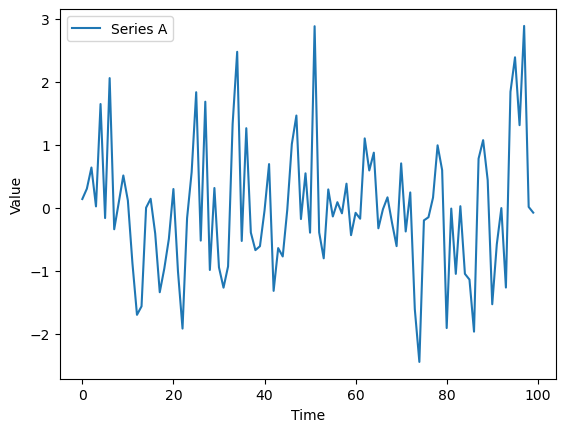

In [15]:

plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A']);

Inductively Building Up Orders of Integration:

If one takes an I(0) series and cumulatively sums it (discrete integration), the new series will be I(1). Notice how this is related to the calculus concept of integration. The same relation applies in general--to get I(n), take an I(0) series and iteratively take the cumulative sum n times.

Now let's make an I(1) series by taking the cumulative sum of A.


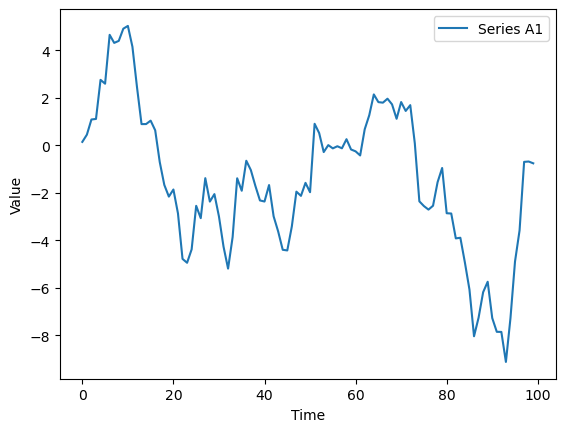

In [ ]:
A1 = np.cumsum(A) ## LOL

plt.plot(A1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A1']);

Now let's make one I(2) by taking the cumlulative sum again.

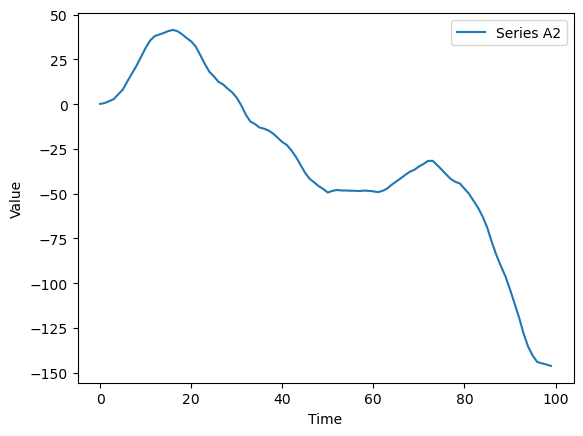

In [14]:
A2 = np.cumsum(A1) #LOLLLL

plt.plot(A2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A2']);

See slides to learn about Breaking Down Orders of Integration


Real Data:


Let's try this out on some real pricing data.

In [28]:
### YFINANCE APIs DOWN AT THE TIME OF WRITING, SEE NEXT CELL


import yfinance as yf
import pandas as pd

# Define the stock symbol
msft_ticker = 'MSFT'

prices = yf.download(
    msft_ticker, 
    start="2024-01-01", 
    end="2025-01-01", 
    interval="1d")['Close'] 

prices = prices.rename("MSFT")

X = prices

print(X.head())

Failed to get ticker 'MSFT' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Empty DataFrame
Columns: [MSFT]
Index: []


In [31]:
#Fetch some MSFT data
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2011, 1, 1)

prices = web.DataReader("MSFT", "stooq", start, end)

prices = prices.sort_index() #reorder the data

prices = prices[["Close"]]
prices = prices.rename(columns={"Close": "MSFT"})

X = prices["MSFT"]

#print(X.head())

In [33]:
check_for_stationarity(X);

p-value = 0.2880841393963077 The series MSFT is likely non-stationary.



Let's take a look, certainly has the warning signs of a non-stationary series.

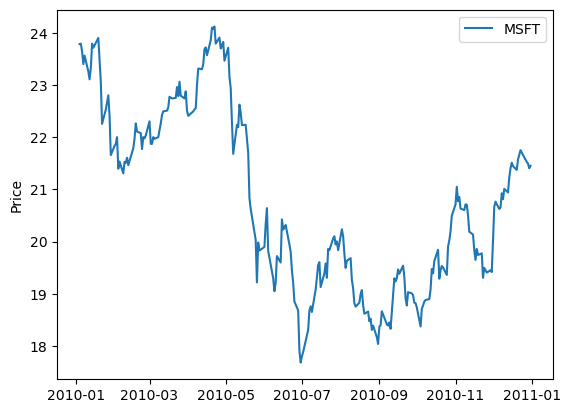

In [34]:
# let's plot it


plt.plot(X.index, X.values)
plt.ylabel('Price')
plt.legend([X.name]);


Now let's take the delta of the series, giving us the additive returns. We'll check if this is stationary.

p-value = 3.6968708912611954e-16 The series MSFT Additive Returns is likely stationary.


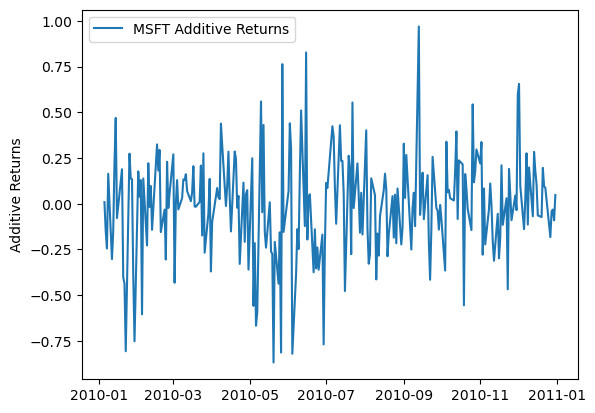

In [35]:
X1 = X.diff()[1:]
X1.name = X.name + ' Additive Returns'
check_for_stationarity(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Additive Returns')
plt.legend([X1.name]);

Seems like the additive returns are stationary over 2010. That means we will probably be able to model the returns much better than the price. It also means that the price was I(1).

Let's also check the multiplicative returns.



p-value = 3.161724223184002e-16 The series MSFT Multiplicative Returns is likely stationary.


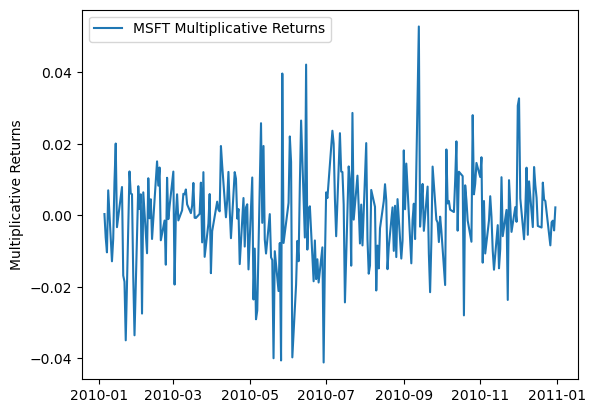

In [36]:
X1 = X.pct_change()[1:]
X1.name = X.name + ' Multiplicative Returns'
check_for_stationarity(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Multiplicative Returns')
plt.legend([X1.name]);

Seems like the multiplicative returns are also stationary. Both the multiplicative and additive deltas on a series get at similar pieces of information, so it's not surprising both are stationary. In practice this might not always be the case.

MPORTANT NOTE


As always, you should not naively assume that because a time series is stationary in the past it will continue to be stationary in the future. Tests for consistency of stationarity such as cross validation and out of sample testing are necessary. This is true of any statistical property, we just reiterate it here. Returns may also go in and out of stationarity, and may be stationary or non-stationary depending on the timeframe and sampling frequency.

Note: Returns Analysis


The reason returns are usually used for modeling in quantitive finance is that they are far more stationary than prices. This makes them easier to model and returns forecasting more feasible. Forecasting prices is more difficult, as there are many trends induced by their I(1) integration. Even using a returns forecasting model to forecast price can be tricky, as any error in the returns forecast will be magnified over time.

**Cointegration**

Finally, now that we've discussed stationarity and order of integration, we can discuss cointegration.

Formal Definition of Cointegration: For some set of time series, if all series are I(1), and some linear combination of them is I(0), we say the set of time series is COINTEGRATED.

**Intuition**

The intuition here is that for some linear combination of the series, the result lacks much auto-covariance and is mostly noise. This is useful for cases such as pairs trading, in which we find two assets whose prices are cointegrated. Since the linear combination of their prices is noise, we can bet on the relationship being mean reverting and place trades accordingly. See the Pairs Trading Lecture for more information.


**Simulated Data Example**

Let's make some data to demonstrate this.

In [37]:
# Length of series
N = 100

# Generate a stationary random X1
X1 = np.random.normal(0, 1, N)
# Integrate it to make it I(1)
X1 = np.cumsum(X1)
X1 = pd.Series(X1)
X1.name = 'X1'

# Make an X2 that is X1 plus some noise
X2 = X1 + np.random.normal(0, 1, N)
X2.name = 'X2'

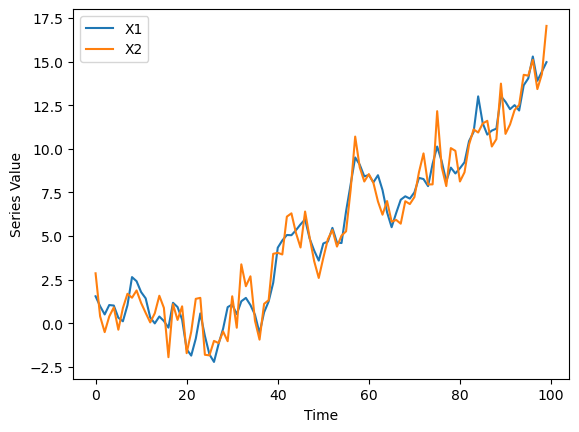

In [38]:

plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);


Because X2 is just a I(1) series plus some stationary noise, it should still be I(1). Let's check this.

In [39]:
Z = X2.diff()[1:]
Z.name = 'Z'

check_for_stationarity(Z);

p-value = 1.373778804571026e-12 The series Z is likely stationary.


Looks good.
Now to show cointegration we'll need to find some linear combination of X1 and X2 that is stationary. 
We can take X2−X1. All that's left over should be stationary noise by design. 
Let's check this.


p-value = 7.979741790752989e-12 The series Z is likely stationary.


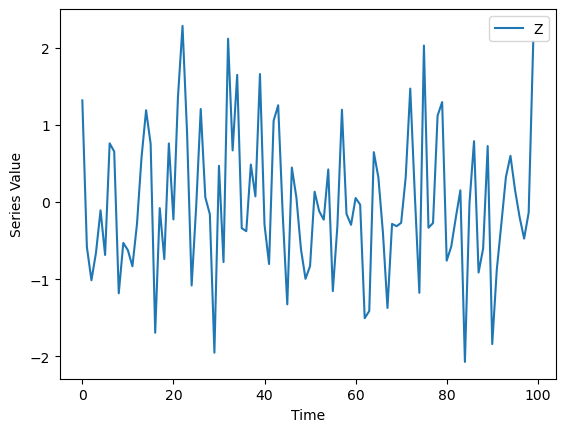

In [40]:
Z = X2 - X1
Z.name = 'Z'

plt.plot(Z)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(['Z']);

check_for_stationarity(Z);

**Testing for Cointegration**

There are a bunch of ways to test for cointegration. This wikipedia article describes some https://en.wikipedia.org/wiki/Cointegration. In general we're just trying to solve for the coefficients b1,..,bk that will produce an I(0) linear combination. If our best guess for these coefficients does not pass a stationarity check, then we reject the hypothesis that the set is cointegrated. This will lead to risk of Type II errors (false negatives), as we will not exhaustively test for stationarity on all coefficent combinations. However Type II errors are generally okay here, as they are safe and do not lead to us making any wrong forecasts.

In practice a common way to do this for pairs of time series is to use linear regression to estimate B in the following model:

X2 = a + BX1 + e (please see the slides for actual notation, I don't know how to do LaTex or real notation in python....)

The idea is that if the two are cointegrated we can remove 
X2
's depedency on X1, leaving behind stationary noise. The combination X2 − β*X1 = α + ϵ should be stationary.


**Real Data Example**

Let's try on some real data. We'll get prices and plot them first.

In [43]:
symbols = ["GLD", "GDX"]
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2011, 1, 1)

# fetch data from Stooq
prices = web.DataReader(symbols, "stooq", start, end)

# stooq returns data in descending order, so we flip it
prices = prices.sort_index()

prices = prices["Close"]

X1 = prices["GLD"]
X2 = prices["GDX"]

# print first few rows...make sure we're chillin
print(X1.head(), "\n")
print(X2.head())

Date
2010-01-04    109.80
2010-01-05    109.70
2010-01-06    111.51
2010-01-07    110.82
2010-01-08    111.37
Name: GLD, dtype: float64 

Date
2010-01-04    43.1632
2010-01-05    43.5781
2010-01-06    44.6380
2010-01-07    44.4208
2010-01-08    45.0903
Name: GDX, dtype: float64


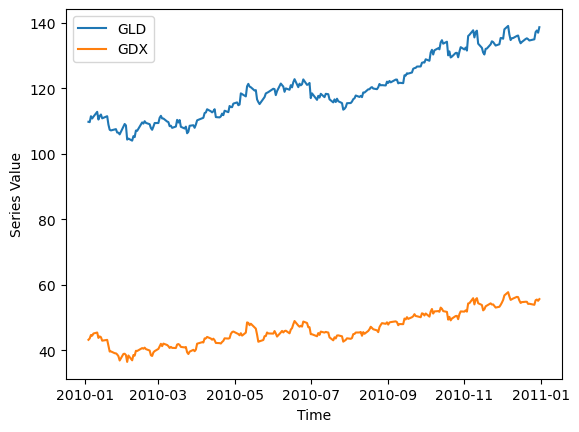

In [44]:
plt.plot(X1.index, X1.values)
plt.plot(X1.index, X2.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);

Now use linear regression to compute Beta.

In [46]:
X1 = sm.add_constant(X1)
results = sm.OLS(X2, X1).fit()

# Get rid of the constant column
X1 = X1['GLD']

results.params

const   -15.977313
GLD       0.520428
dtype: float64

Now check for stationarity

p-value = 0.0001859729621445718 The series Z is likely stationary.


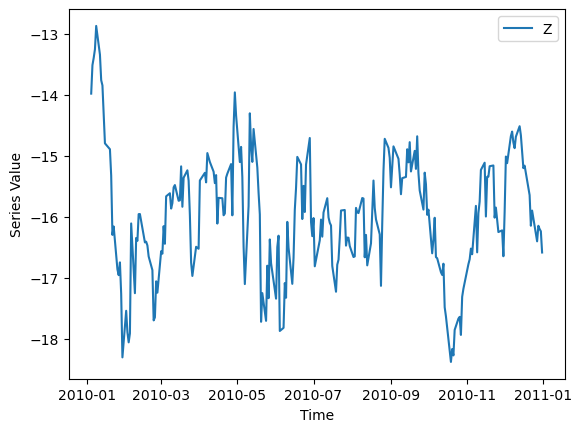

In [47]:
b = results.params['GLD']
Z = X2 - b * X1
Z.name = 'Z'

plt.plot(Z.index, Z.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([Z.name]);

check_for_stationarity(Z);

We can see here that the resulting Z was likely stationary over the time frame we looked at. This causes us to accept the hypothesis that our two assets were cointegrated over the same timeframe.

**This is only a forecast!**


Remember as with anything else, you should not assume that because some set of assets have passed a cointegration test historically, they will continue to remain cointegrated. You need to verify that consistent behavior occurs, and use various model validation techniques as you would with any model.

One of the most important things done in finance is to make many independent bets. Here a quant would find many pairs of assets they hypothesize are cointegrated, and evenly distribute their dollars between them in bets. This only requires more than half of the asset pairs to remain cointegrated for the strategy to work.

**Existing Tests**

Luckily, there are some prebuilt tests for cointegration. Here’s one. Read up on the statsmodel documentation for more https://pypi.org/project/statsmodels/ 

In [48]:
from statsmodels.tsa.stattools import coint

coint(X1, X2)

(-4.4394173764073175,
 0.0015375122274708167,
 array([-3.94060523, -3.36058133, -3.06139039]))